In [15]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# importar archivos csv
crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)
crossBattlelog.info()

C:\Users\alniquia\AppData\Local\Temp\ipykernel_8380\3354061991.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 108603 entries, 0 to 108602
Data columns (total 63 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   battleTime                             108603 non-null  object 
 1   playertag                              108603 non-null  object 
 2   event.id                               108603 non-null  int64  
 3   event.mode                             108603 non-null  object 
 4   event.map                              108603 non-null  object 
 5   battle.mode                            108603 non-null  object 
 6   battle.type                            108603 non-null  object 
 7   battle.rank                            0 non-null       float64
 8   battle.trophyChange                    79436 non-null   float64
 9   battle.players                         0 non-null       float64
 10  battle.result                          108603 non-null  

In [17]:
# importar archivos csv
players = pd.read_csv('datasets/players/players.csv', index_col=0)
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85895 entries, 0 to 85894
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tag                                   85895 non-null  object 
 1   name                                  85894 non-null  object 
 2   nameColor                             83449 non-null  object 
 3   icon                                  5038 non-null   object 
 4   trophies                              85895 non-null  int64  
 5   highestTrophies                       85895 non-null  int64  
 6   highestPowerPlayPoints                62736 non-null  float64
 7   expLevel                              85895 non-null  int64  
 8   expPoints                             85895 non-null  int64  
 9   isQualifiedFromChampionshipChallenge  85895 non-null  bool   
 10  3vs3Victories                         85895 non-null  int64  
 11  soloVictories  

C:\Users\alniquia\AppData\Local\Temp\ipykernel_8380\611356329.py:2: DtypeWarning: Columns (4,16) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv('datasets/players/players.csv', index_col=0)


In [18]:
# importar archivos csv
brawlers = pd.read_csv('datasets/brawlers/brawlers_stats.csv', index_col=0)
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      64 non-null     int64 
 1   name    64 non-null     object
 2   role    64 non-null     object
 3   range   64 non-null     object
 4   speed   64 non-null     object
 5   health  64 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.5+ KB


In [19]:
# crear columna playerteam
for i in range(len(crossBattlelog)):
	if any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team1.player1.tag'], crossBattlelog.loc[i, 'battle.team1.player2.tag'], crossBattlelog.loc[i, 'battle.team1.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team1'
	elif any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team2.player1.tag'], crossBattlelog.loc[i, 'battle.team2.player2.tag'], crossBattlelog.loc[i, 'battle.team2.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team2'
	else:
		print("error in team assignation for id " + str(i))

crossBattlelog['player_team'].value_counts()

team1    54693
team2    53910
Name: player_team, dtype: int64

In [20]:
# crear columna winner_team
for i in range(len(crossBattlelog)):
	if crossBattlelog.loc[i, 'battle.result'] == 'draw':
		crossBattlelog.loc[i, 'winner_team'] = 'draw'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	else:
		print("error in winner assignation for id " + str(i))

crossBattlelog['winner_team'].value_counts()

team1    54732
team2    53293
draw       578
Name: winner_team, dtype: int64

In [21]:
# agregar columna identificando batallas levelup y definir subset
for i in range(len(crossBattlelog)):

	t1p1 = crossBattlelog.loc[i, 'battle.team1.player1.brawler.trophies']
	t1p2 = crossBattlelog.loc[i, 'battle.team1.player2.brawler.trophies']
	t1p3 = crossBattlelog.loc[i, 'battle.team1.player3.brawler.trophies']
	t2p1 = crossBattlelog.loc[i, 'battle.team2.player1.brawler.trophies']
	t2p2 = crossBattlelog.loc[i, 'battle.team2.player2.brawler.trophies']
	t2p3 = crossBattlelog.loc[i, 'battle.team2.player3.brawler.trophies']

	if  (t1p1 <= 350 or t1p2 <= 350 or t1p3 <= 350 or t2p1 <= 350 or t2p2 <= 350 or t2p3 <= 350):
		crossBattlelog.loc[i, 'low_trophy'] = 'y'
	else:
		crossBattlelog.loc[i, 'low_trophy'] = 'n'

crossBattlelog = crossBattlelog[crossBattlelog['low_trophy'] == 'n'].reset_index(drop=True)

crossBattlelog.shape

(66297, 66)

In [22]:
# format date
for i, battleTime in enumerate(crossBattlelog['battleTime']):	
	crossBattlelog.loc[i, 'battleTime'] = pd.to_datetime(crossBattlelog.loc[i, 'battleTime'])
crossBattlelog['battleTime']

0        2023-01-17 16:41:38+00:00
1        2023-01-17 16:37:14+00:00
2        2023-01-17 16:34:07+00:00
3        2023-01-17 16:31:42+00:00
4        2023-01-17 16:29:17+00:00
                   ...            
66292    2022-12-31 15:14:10+00:00
66293    2023-01-02 04:18:29+00:00
66294    2023-01-02 04:05:44+00:00
66295    2023-01-01 16:35:13+00:00
66296    2023-01-02 02:19:30+00:00
Name: battleTime, Length: 66297, dtype: object

In [23]:
# crear columna winner
def clean_winner(team):

	dfw = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(dfw['winner_team']):
		if winner_team == 'draw':
			winner = 'd'
		elif winner_team == team:
			winner = 'y'
		else:
			winner = 'n'
		
		dfw.loc[i, 'winner'] = winner

	dfw = dfw.drop('winner_team', axis=1)

	dfw = dfw.rename(columns={
		'battle.' + team + '.player1.tag': 'battle.player1.tag'
		,'battle.' + team + '.player1.brawler.name': 'battle.player1.brawler.name'
		,'battle.' + team + '.player1.brawler.power': 'battle.player1.brawler.power'
		,'battle.' + team + '.player1.brawler.trophies': 'battle.player1.brawler.trophies'
		,'battle.' + team + '.player2.tag': 'battle.player2.tag'
		,'battle.' + team + '.player2.brawler.name': 'battle.player2.brawler.name'
		,'battle.' + team + '.player2.brawler.power': 'battle.player2.brawler.power'
		,'battle.' + team + '.player2.brawler.trophies': 'battle.player2.brawler.trophies'
		,'battle.' + team + '.player3.tag': 'battle.player3.tag'
		,'battle.' + team + '.player3.brawler.name': 'battle.player3.brawler.name'
		,'battle.' + team + '.player3.brawler.power': 'battle.player3.brawler.power'
		,'battle.' + team + '.player3.brawler.trophies': 'battle.player3.brawler.trophies'
	})

	dfw = dfw[[	
		'battleTime'
		,'event.mode'
		,'event.map'
		,'battle.type'
		,'battle.duration'
		,'battle.trophyChange'
		,'battle.starPlayer.tag'
 		,'battle.starPlayer.brawler.name'
 		,'battle.starPlayer.brawler.power'
 		,'battle.starPlayer.brawler.trophies'
		,'battle.player1.tag'
		,'battle.player1.brawler.name'
		,'battle.player1.brawler.power'
		,'battle.player1.brawler.trophies'
		,'battle.player2.tag'
		,'battle.player2.brawler.name'
		,'battle.player2.brawler.power'
		,'battle.player2.brawler.trophies'
		,'battle.player3.tag'
		,'battle.player3.brawler.name'
		,'battle.player3.brawler.power'
		,'battle.player3.brawler.trophies'
		,'winner'
	]]

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	dfl = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(dfl['winner_team']):
		if winner_team == 'draw':
			winner = 'd'
		elif winner_team == oteam:
			winner = 'y'
		else:
			winner = 'n'
		
		dfl.loc[i, 'winner'] = winner

	dfl = dfl.drop('winner_team', axis=1)

	dfl = dfl.rename(columns={
		'battle.' + oteam + '.player1.tag': 'battle.player1.tag'
		,'battle.' + oteam + '.player1.brawler.name': 'battle.player1.brawler.name'
		,'battle.' + oteam + '.player1.brawler.power': 'battle.player1.brawler.power'
		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.player1.brawler.trophies'
		,'battle.' + oteam + '.player2.tag': 'battle.player2.tag'
		,'battle.' + oteam + '.player2.brawler.name': 'battle.player2.brawler.name'
		,'battle.' + oteam + '.player2.brawler.power': 'battle.player2.brawler.power'
		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.player2.brawler.trophies'
		,'battle.' + oteam + '.player3.tag': 'battle.player3.tag'
		,'battle.' + oteam + '.player3.brawler.name': 'battle.player3.brawler.name'
		,'battle.' + oteam + '.player3.brawler.power': 'battle.player3.brawler.power'
		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.player3.brawler.trophies'
	})

	dfl = dfl[[	
		'battleTime'
		,'event.mode'
		,'event.map'
		,'battle.type'
		,'battle.duration'
		,'battle.trophyChange'
		,'battle.starPlayer.tag'
 		,'battle.starPlayer.brawler.name'
 		,'battle.starPlayer.brawler.power'
 		,'battle.starPlayer.brawler.trophies'
		,'battle.player1.tag'
		,'battle.player1.brawler.name'
		,'battle.player1.brawler.power'
		,'battle.player1.brawler.trophies'
		,'battle.player2.tag'
		,'battle.player2.brawler.name'
		,'battle.player2.brawler.power'
		,'battle.player2.brawler.trophies'
		,'battle.player3.tag'
		,'battle.player3.brawler.name'
		,'battle.player3.brawler.power'
		,'battle.player3.brawler.trophies'
		,'winner'
	]]

	return pd.concat([dfw, dfl], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True).reset_index(drop = True)
battlelogProcess.info()

,battleTime,event.mode,event.map,battle.type,battle.duration,battle.trophyChange,battle.starPlayer.tag,battle.starPlayer.brawler.name,battle.starPlayer.brawler.power,battle.starPlayer.brawler.trophies,...,battle.player1.brawler.trophies,battle.player2.tag,battle.player2.brawler.name,battle.player2.brawler.power,battle.player2.brawler.trophies,battle.player3.tag,battle.player3.brawler.name,battle.player3.brawler.power,battle.player3.brawler.trophies,winner
0,2023-01-17 16:41:38+00:00,brawlBall,Beach Ball,ranked,111.0,-9.0,#2J8YUYUCQ,DYNAMIKE,11.0,866.0,...,851.0,#P9P9QC9PG,RICO,11.0,820.0,#2LPPP0JCQ,PENNY,10.0,814.0,n
1,2023-01-17 16:37:14+00:00,knockout,Goldarm Gulch,ranked,140.0,-9.0,#GRQYGUQ8,JACKY,11.0,858.0,...,828.0,#P9P9QC9PG,RICO,11.0,838.0,#2LPPP0JCQ,RUFFS,10.0,855.0,n
2,2023-01-17 16:31:42+00:00,knockout,Goldarm Gulch,ranked,101.0,-8.0,#90CCVGRP0,MAX,11.0,848.0,...,852.0,#P9P9QC9PG,RICO,11.0,856.0,#2LPPP0JCQ,BROCK,10.0,778.0,n
3,2023-01-17 16:29:17+00:00,knockout,Goldarm Gulch,ranked,140.0,-9.0,#2JPUR9UCY,GRAY,10.0,354.0,...,861.0,#P9P9QC9PG,RICO,11.0,865.0,#2LPPP0JCQ,RUFFS,10.0,864.0,n
4,2023-01-17 16:26:36+00:00,knockout,Goldarm Gulch,ranked,94.0,7.0,#9LYUUJPYG,PIPER,10.0,854.0,...,854.0,#P9P9QC9PG,RICO,11.0,858.0,#2LPPP0JCQ,RUFFS,10.0,857.0,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132589,2023-01-02 03:39:12+00:00,gemGrab,Double Swoosh,ranked,91.0,4.0,#UJQPQP0C,CHESTER,11.0,1198.0,...,1031.0,#2C2CVCG0,MEG,11.0,862.0,#2VQR2Y0G,CHESTER,11.0,883.0,n
132590,2022-12-31 15:14:10+00:00,heist,Bridge Too Far,ranked,150.0,6.0,#LCP2LUP2,BROCK,11.0,945.0,...,1128.0,#9L8LUQYV9,BEA,11.0,1164.0,#PPG8C2P2,AMBER,11.0,1027.0,n
132591,2023-01-02 04:18:29+00:00,hotZone,Quarter Pounder,ranked,66.0,7.0,#2CYY2QPVR,BARLEY,10.0,809.0,...,726.0,#9QUGVRJJG,FRANK,10.0,679.0,#L8UUGVUJ2,BULL,11.0,768.0,n
132592,2023-01-02 04:05:44+00:00,gemGrab,Double Swoosh,ranked,90.0,-12.0,#20C8G8C8V,ASH,11.0,915.0,...,817.0,#8U02UQYJP,PENNY,10.0,972.0,#20C8G8C8V,ASH,11.0,915.0,y


In [24]:
# agregar brawler stats
def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers.add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogProcess = add_brawlers(battlelogProcess, 'battle.player1.brawler.')
battlelogProcess = add_brawlers(battlelogProcess, 'battle.player2.brawler.')
battlelogProcess = add_brawlers(battlelogProcess, 'battle.player3.brawler.')

battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132594 entries, 0 to 132593
Data columns (total 38 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   battleTime                          132594 non-null  object 
 1   event.mode                          132594 non-null  object 
 2   event.map                           132594 non-null  object 
 3   battle.type                         132594 non-null  object 
 4   battle.duration                     132594 non-null  float64
 5   battle.trophyChange                 131706 non-null  float64
 6   battle.starPlayer.tag               132592 non-null  object 
 7   battle.starPlayer.brawler.name      132592 non-null  object 
 8   battle.starPlayer.brawler.power     132592 non-null  float64
 9   battle.starPlayer.brawler.trophies  132592 non-null  float64
 10  battle.player1.tag                  132594 non-null  object 
 11  battle.player1.brawler.nam

In [25]:
# unificar bases de brawlers
bk1 = battlelogProcess.rename(columns={'battle.player1.brawler.name': 'brawlername'})
bk2 = battlelogProcess.rename(columns={'battle.player2.brawler.name': 'brawlername'})
bk3 = battlelogProcess.rename(columns={'battle.player3.brawler.name': 'brawlername'})

brawler = pd.concat([
bk1[['event.mode','event.map','battle.type','brawlername','winner']], 
bk2[['event.mode','event.map','battle.type','brawlername','winner']], 
bk3[['event.mode','event.map','battle.type','brawlername','winner']]
], ignore_index=True)

brawler

,event.mode,event.map,battle.type,brawlername,winner
0,brawlBall,Beach Ball,ranked,DYNAMIKE,n
1,knockout,Goldarm Gulch,ranked,GENE,n
2,knockout,Goldarm Gulch,ranked,PIPER,n
3,knockout,Goldarm Gulch,ranked,PIPER,n
4,knockout,Goldarm Gulch,ranked,PIPER,y
...,...,...,...,...,...
397777,gemGrab,Double Swoosh,ranked,CHESTER,n
397778,heist,Bridge Too Far,ranked,AMBER,n
397779,hotZone,Quarter Pounder,ranked,BULL,n
397780,gemGrab,Double Swoosh,ranked,ASH,y


In [26]:
brawler['winner'].value_counts()

n    197748
y    197748
d      2286
Name: winner, dtype: int64

In [27]:
# crear pivot tables
pivot_brawler = brawler.pivot_table(index=['brawlername','event.mode','event.map'], columns='winner', values='winner', aggfunc='size', fill_value=0).reset_index(drop=False)
pivot_brawler

winner,brawlername,event.mode,event.map,d,n,y
0,8-BIT,bounty,Canal Grande,0,2,0
1,8-BIT,bounty,Dry Season,0,3,0
2,8-BIT,bounty,Hideout,0,6,3
3,8-BIT,bounty,Layer Cake,0,3,0
4,8-BIT,bounty,Shooting Star,0,41,32
...,...,...,...,...,...,...
2641,TICK,knockout,Goldarm Gulch,0,96,76
2642,TICK,knockout,New Perspective,0,30,4
2643,TICK,knockout,Out in the Open,1,443,350
2644,TICK,knockout,Riverside,0,26,14


In [28]:
# agregar columna totales, win y draw

pivot_brawler['total_games'] = pivot_brawler['d'] + pivot_brawler['n'] + pivot_brawler['y']
pivot_brawler['winrate'] = pivot_brawler['y'] / pivot_brawler['total_games']

total_games_per_map = pivot_brawler[['event.mode','event.map','total_games']].groupby(['event.mode','event.map']).sum()

pivot_brawler = pivot_brawler.merge(total_games_per_map, on=['event.mode','event.map'], suffixes=('', '_map'))

pivot_brawler['userate'] = pivot_brawler['total_games'] / pivot_brawler['total_games_map']

pivot_brawler = pivot_brawler.sort_values(by=['brawlername','event.mode','event.map'], ascending=False).reset_index(drop=True)

pivot_brawler

winner,brawlername,event.mode,event.map,d,n,y,total_games,winrate,total_games_map,userate
0,TICK,knockout,X Marks the Spot,0,69,18,87,0.206897,2712,0.032080
1,TICK,knockout,Riverside,0,26,14,40,0.350000,2958,0.013523
2,TICK,knockout,Out in the Open,1,443,350,794,0.440806,24234,0.032764
3,TICK,knockout,New Perspective,0,30,4,34,0.117647,1734,0.019608
4,TICK,knockout,Goldarm Gulch,0,96,76,172,0.441860,6324,0.027198
...,...,...,...,...,...,...,...,...,...,...
2641,8-BIT,bounty,Shooting Star,0,41,32,73,0.438356,19848,0.003678
2642,8-BIT,bounty,Layer Cake,0,3,0,3,0.000000,2046,0.001466
2643,8-BIT,bounty,Hideout,0,6,3,9,0.333333,6774,0.001329
2644,8-BIT,bounty,Dry Season,0,3,0,3,0.000000,3222,0.000931


In [29]:
# export brawler_by_event_map
pivot_brawler.to_csv('datasets/teams/brawler_by_event_map.csv')

In [49]:
# función que crea distribución por gamemode
def dist_gamemode(gamemode):
	df = pivot_brawler[(pivot_brawler['event.mode']==gamemode)].groupby(['brawlername','event.mode']).sum(['d', 'n', 'y', 'total_games', 'total_games_map']).sort_values(by=['winrate'], ascending=False).reset_index()
	df['winrate'] = df['y'] / df['total_games']
	df['userate'] = df['total_games'] / df['total_games_map']
	return df

# función que crea distribución por brawler general
def dist_brawler_g():
	df = pivot_brawler.groupby(['brawlername']).sum(['d', 'n', 'y', 'total_games', 'total_games_map']).sort_values(by=['winrate'], ascending=False).reset_index()
	df['winrate'] = df['y'] / df['total_games']
	df['userate'] = df['total_games'] / df['total_games_map']
	return df

#función que crea distribución por brawler
def dist_brawler(brawler):
	df = pivot_brawler[(pivot_brawler['brawlername']==brawler)].groupby(['event.mode']).sum(['d', 'n', 'y', 'total_games', 'total_games_map']).sort_values(by=['winrate'], ascending=False).reset_index()
	df['winrate'] = df['y'] / df['total_games']
	df['userate'] = df['total_games'] / df['total_games_map']
	return df

#función que crea distribución por gamemode y map
def dist_gamemode_map(gamemode, map):
	df = pivot_brawler[(pivot_brawler['event.mode']==gamemode) & (pivot_brawler['event.map']==map)].groupby(['brawlername']).sum(['d', 'n', 'y', 'total_games', 'total_games_map']).sort_values(by=['winrate'], ascending=False).reset_index()
	df['winrate'] = df['y'] / df['total_games']
	df['userate'] = df['total_games'] / df['total_games_map']
	return df

In [37]:
# definir estilo de plot
print(plt.style.available)
plt.style.use('seaborn-v0_8-dark-palette')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [32]:
#estilo sns
print(sns.axes_style())
sns.set_theme('paper')

{'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': False, 'axes.axisbelow': 'line', 'axes.labelcolor': 'black', 'figure.facecolor': 'white', 'grid.color': '#b0b0b0', 'grid.linestyle': '-', 'text.color': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>, 'patch.edgecolor': 'black', 'patch.force_edgecolor': False, 'image.cmap': 'viridis', 'font.family': ['sans-serif'], 'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'], 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}


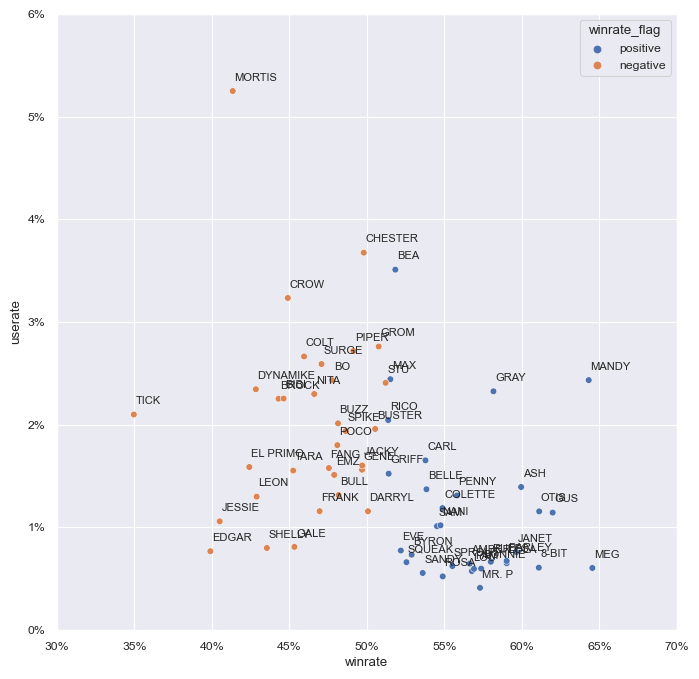

In [33]:
# winrate / userate overall

gamemode = dist_brawler_g()

gamemode['percentile_wr'] = gamemode['winrate'] / gamemode['winrate'].quantile(0.5)
gamemode['winrate_flag'] = np.where(gamemode['percentile_wr'] > 1,'positive','negative')

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
	data=gamemode
	,x="winrate"
	,y="userate"
	,hue='winrate_flag'
	,ax=ax
)

# Añadir etiquetas flotando sobre los puntos
for i, point in gamemode.iterrows():
	ax.text(point.winrate + 0.001, point.userate + 0.001, point.brawlername, fontsize=8)

yticks = ax.get_yticks()
xticks = ax.get_xticks()

ax.set_yticks(yticks)
ax.set_xticks(xticks)

ax.set_yticklabels(["{:,.00%}".format(y) for y in yticks])
ax.set_xticklabels(["{:,.00%}".format(x) for x in xticks])

plt.show()

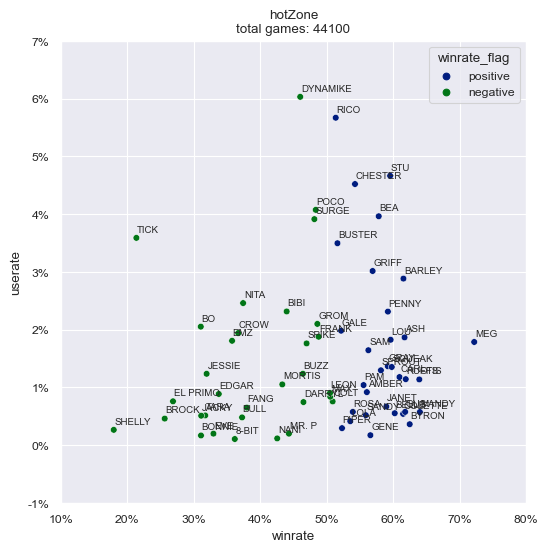

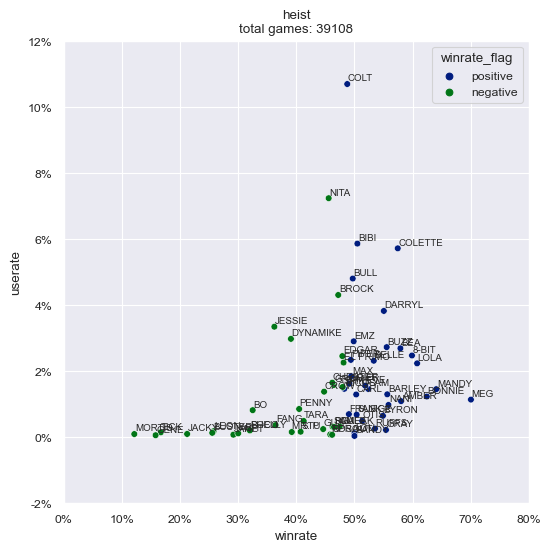

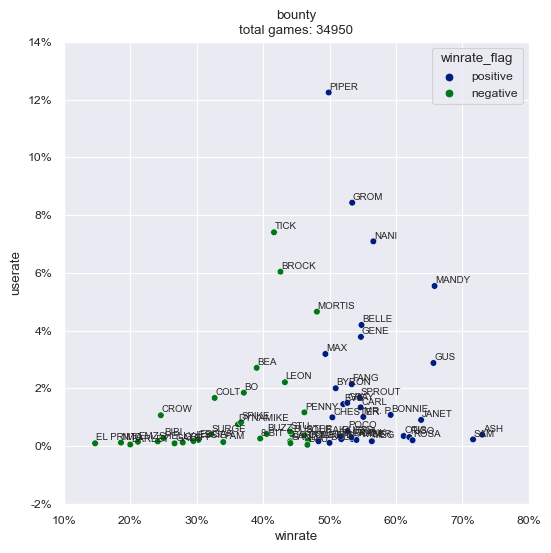

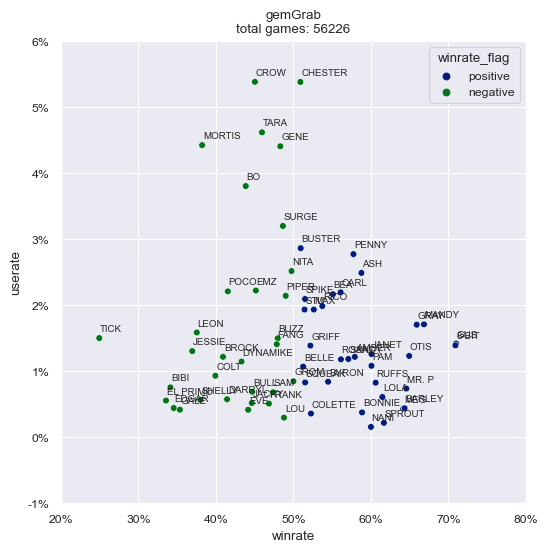

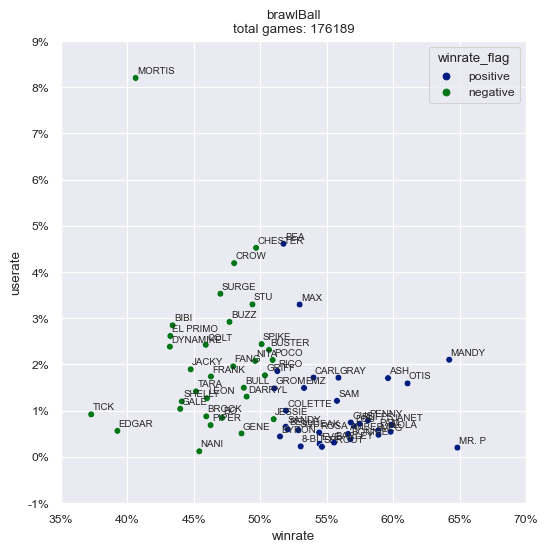

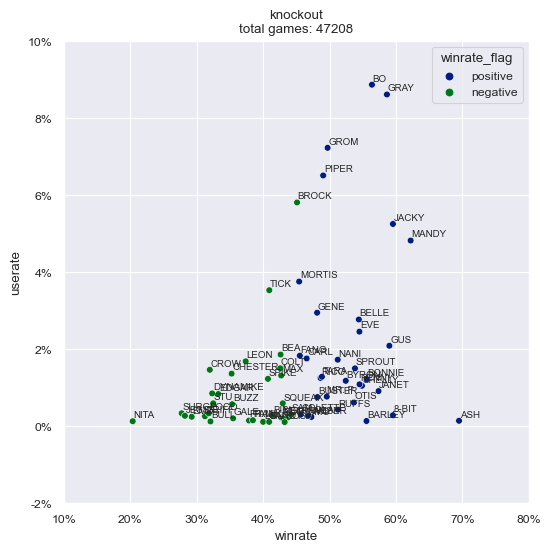

In [79]:
# winrate / userate
gamemodes = ['hotZone','heist','bounty','gemGrab','brawlBall','knockout']

for i, gm in enumerate(gamemodes):
    data = dist_gamemode(gm)

    data['percentile_wr'] = data['winrate'] / data['winrate'].quantile(0.5)
    data['winrate_flag'] = np.where(data['percentile_wr'] > 1,'positive','negative')

    fig, ax = plt.subplots(figsize=(6,6))

    sns.scatterplot(
        data=data
        ,x="winrate"
        ,y="userate"
        ,hue='winrate_flag'
        ,ax=ax
    )

    # Añadir etiquetas flotando sobre los puntos
    for i, point in data.iterrows():
        ax.text(point.winrate + 0.001, point.userate + 0.001, point.brawlername, fontsize=7)

    yticks = ax.get_yticks()
    xticks = ax.get_xticks()

    ax.set_yticks(yticks)
    ax.set_xticks(xticks)

    ax.set_yticklabels(["{:,.00%}".format(y) for y in yticks])
    ax.set_xticklabels(["{:,.00%}".format(x) for x in xticks])
    
    plt.title(str(data['event.mode'][0]) + '\n' + 'total games: ' + str(data['total_games_map'][0]))

    plt.show()

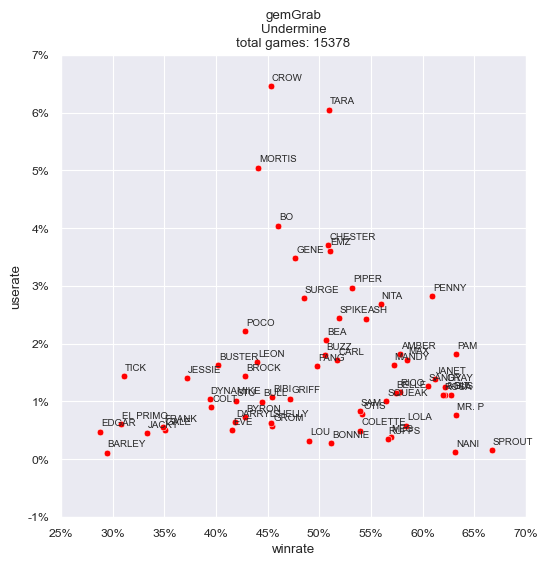

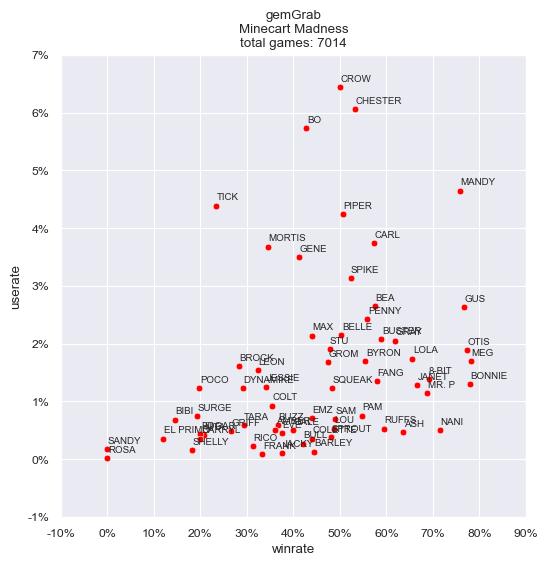

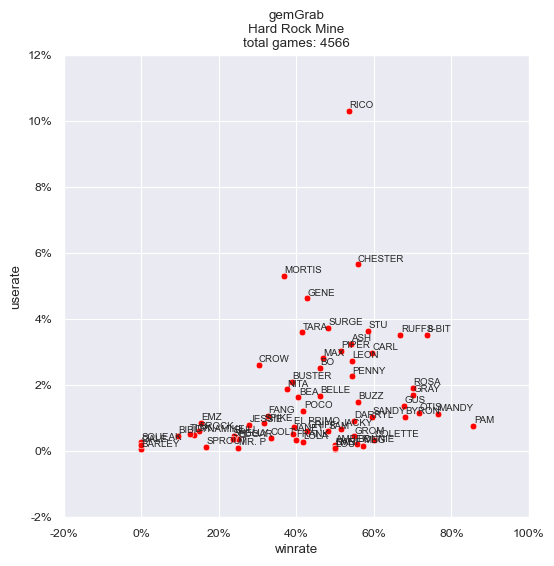

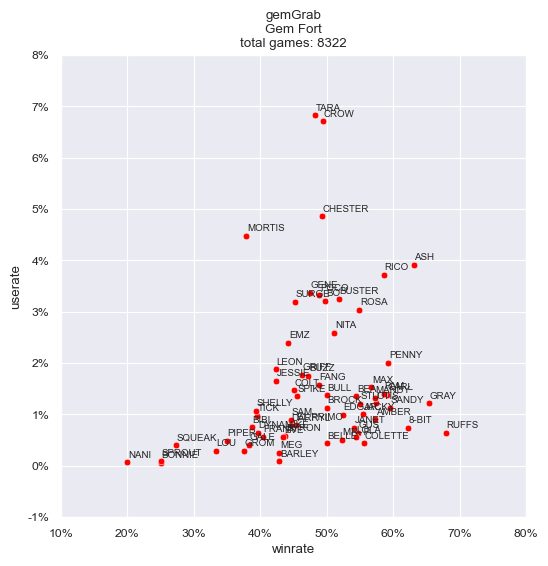

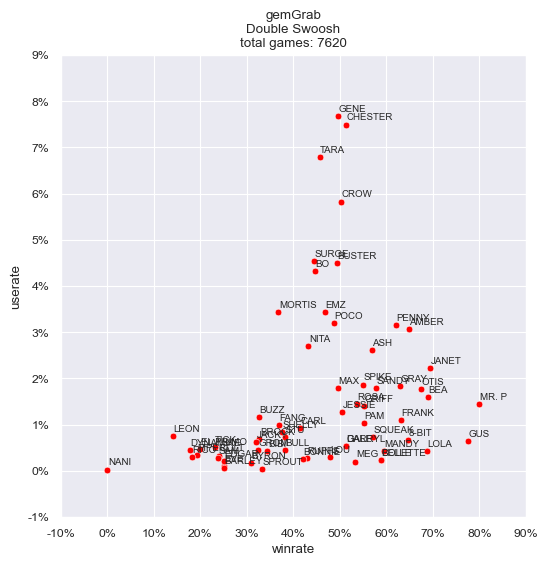

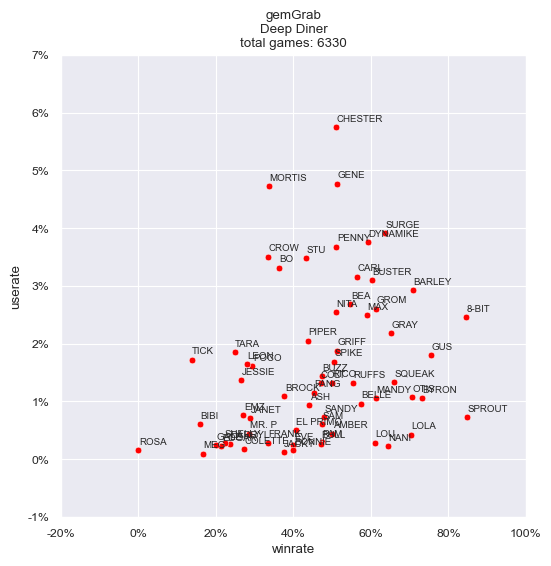

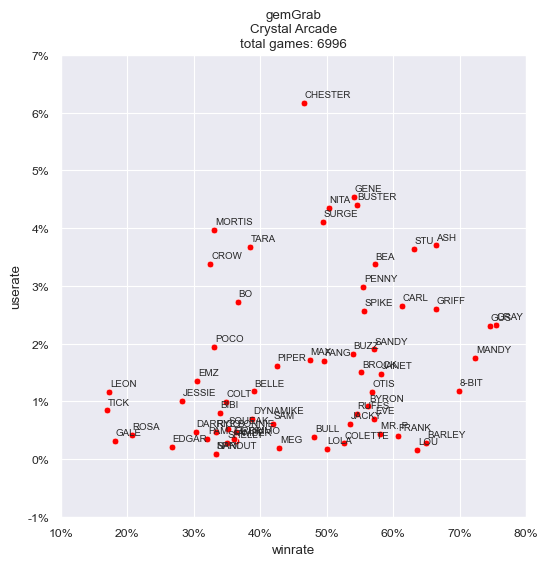

In [77]:
# winrate / userate

gamemode = 'gemGrab'

maps = pivot_brawler['event.map'][pivot_brawler['event.mode'] == gamemode].drop_duplicates().tolist()

for i, item in enumerate(maps):
	data = dist_gamemode_map(gamemode, item)

	fig, ax = plt.subplots(figsize=(6,6))

	sns.scatterplot(
		data=data
		,x="winrate"
		,y="userate"
		,c="red"
		,ax=ax
	)

	# Añadir etiquetas flotando sobre los puntos
	for i, point in data.iterrows():
		ax.text(point.winrate + 0.001, point.userate + 0.001, point.brawlername, fontsize=7)

	yticks = ax.get_yticks()
	xticks = ax.get_xticks()

	ax.set_yticks(yticks)
	ax.set_xticks(xticks)

	ax.set_yticklabels(["{:,.00%}".format(y) for y in yticks])
	ax.set_xticklabels(["{:,.00%}".format(x) for x in xticks])

	plt.title(gamemode + '\n' + item + '\n' + 'total games: ' + str(data['total_games_map'][0]))

	plt.show()

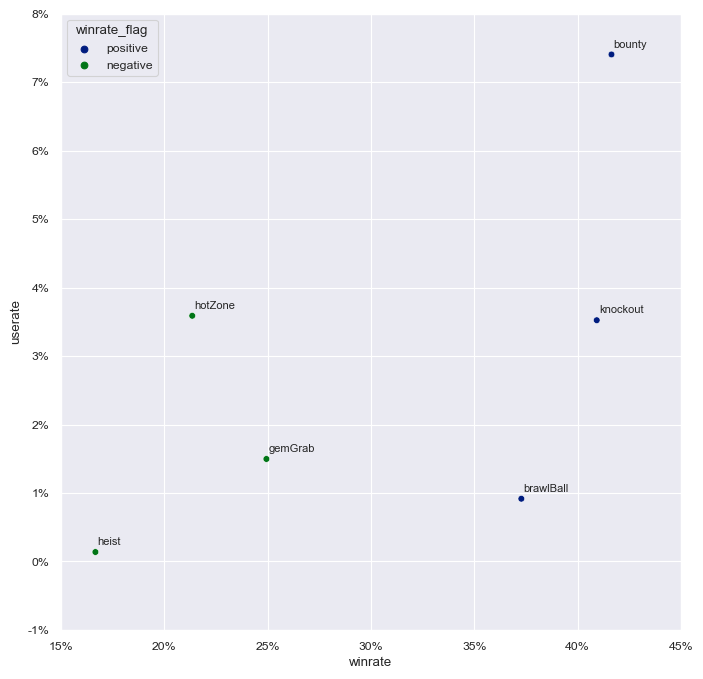

In [76]:
# winrate / userate by brawler

data = dist_brawler('TICK')

data['percentile_wr'] = data['winrate'] / data['winrate'].quantile(0.5)
data['winrate_flag'] = np.where(data['percentile_wr'] > 1,'positive','negative')

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
	data=data
	,x="winrate"
	,y="userate"
	,hue='winrate_flag'
	,ax=ax
)

# Añadir etiquetas flotando sobre los puntos
for i, point in data.iterrows():
	ax.text(point.winrate + 0.001, point.userate + 0.001, point[0], fontsize=8)

yticks = ax.get_yticks()
xticks = ax.get_xticks()

ax.set_yticks(yticks)
ax.set_xticks(xticks)

ax.set_yticklabels(["{:,.00%}".format(y) for y in yticks])
ax.set_xticklabels(["{:,.00%}".format(x) for x in xticks])

plt.show()